In [19]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 52.8MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.25MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [6]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [7]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [8]:
train_data.targets.size()

torch.Size([60000])

In [9]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [11]:
loaders = {
    'train' : DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test' : DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
}

In [12]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7cc04b3fd310>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7cc0431aced0>}

In [14]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320) # 20*4*4
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)

    return F.softmax(x)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(loaders['train']):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\tLoss: {loss.item():.6f}')

def test():
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in loaders['test']:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += loss_fn(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(loaders['test'].dataset)
  print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%)\n')

In [17]:
for epoch in range(1, 11):
  train(epoch)
  test()

<ipython-input-14-4a31a2b00701>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302024
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.292361
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.182533
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.974301
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.946128
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.880350
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.845644
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.812573
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.795210
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.801531
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.778521
Train Epoch: 1 [22000/60000 (37%)]	Loss: 1.794229
Train Epoch: 1 [24000/60000 (40%)]	Loss: 1.735305
Train Epoch: 1 [26000/60000 (43%)]	Loss: 1.717419
Train Epoch: 1 [28000/60000 (47%)]	Loss: 1.765956
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.668525
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.630086
Train Epoch: 1 [34000/60000 (57%)]	Loss: 1.688626
Train Epoch: 1 [36000/60000 (60%)]	Loss: 1.631706
Train Epoch: 1 [38000/60000 (63%)]	Loss: 1.647059
Train Epoch

In [18]:
device

device(type='cpu')

<ipython-input-14-4a31a2b00701>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Prediction: 7


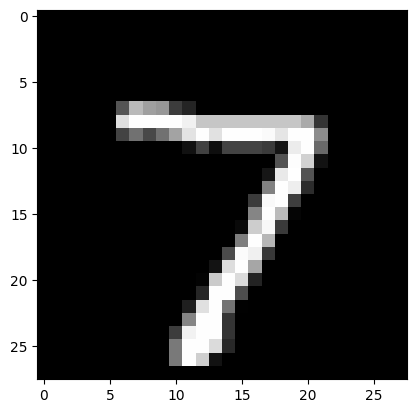

In [20]:
model.eval()

data, target = test_data[0]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()

Image 1: Prediction: 7, True Label: 7


<ipython-input-14-4a31a2b00701>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


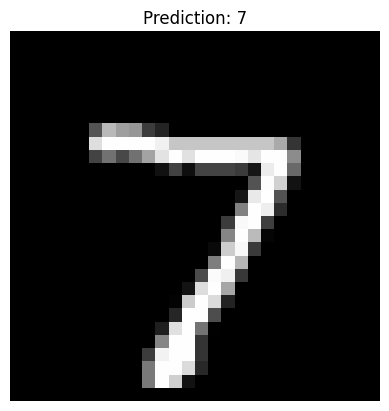

Image 2: Prediction: 2, True Label: 2


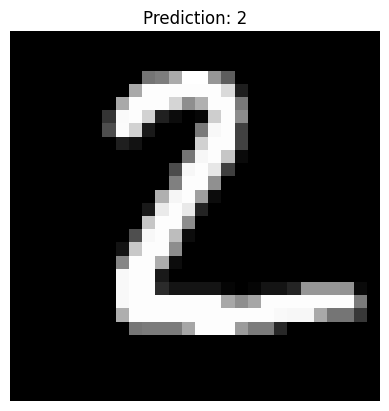

Image 3: Prediction: 1, True Label: 1


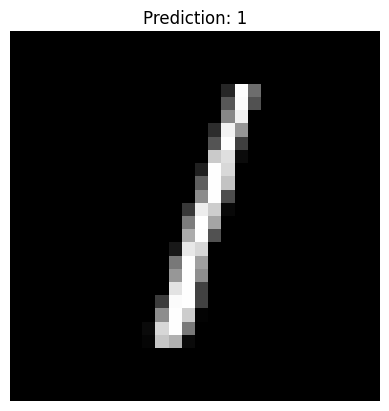

Image 4: Prediction: 0, True Label: 0


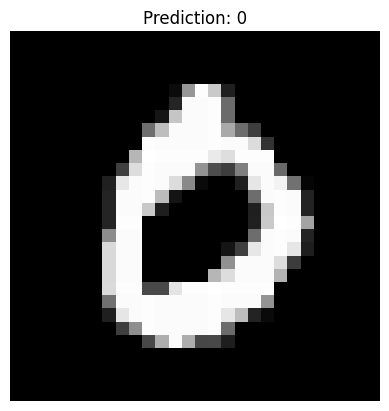

Image 5: Prediction: 4, True Label: 4


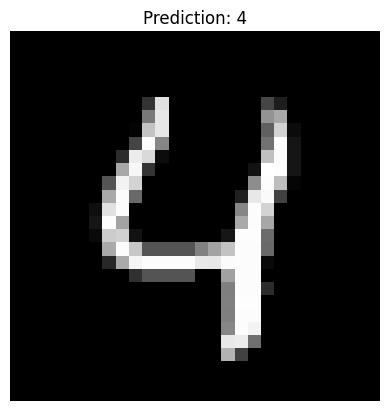

Image 6: Prediction: 1, True Label: 1


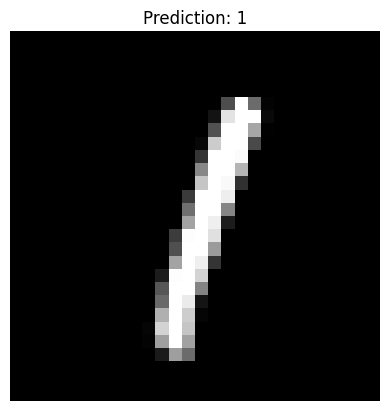

Image 7: Prediction: 4, True Label: 4


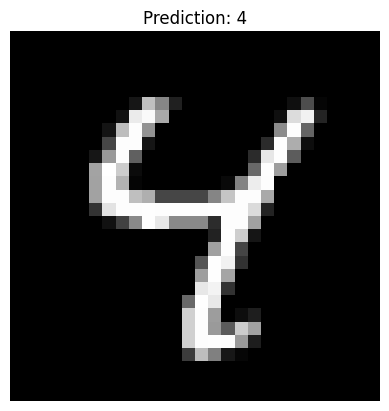

Image 8: Prediction: 9, True Label: 9


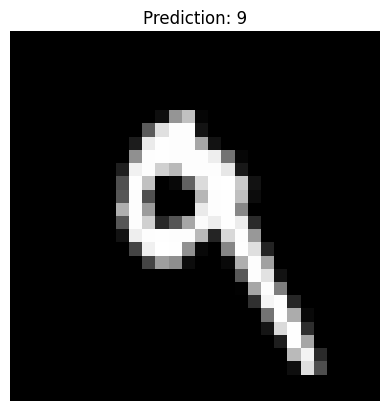

Image 9: Prediction: 5, True Label: 5


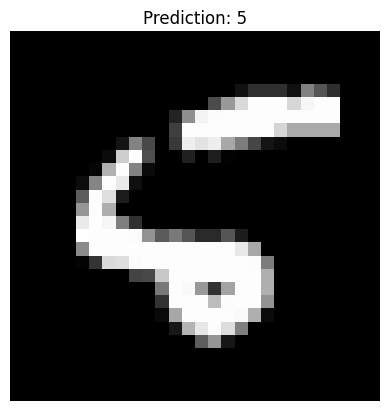

Image 10: Prediction: 9, True Label: 9


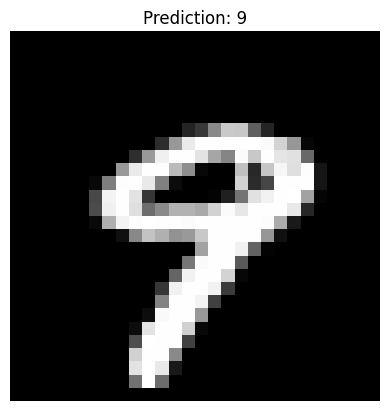

In [23]:
model.eval()

for idx in range(10):
    data, target = test_data[idx]
    data = data.unsqueeze(0).to(device)
    output = model(data)
    prediction = output.argmax(dim=1, keepdim=True).item()
    print(f'Image {idx + 1}: Prediction: {prediction}, True Label: {target}')
    image = data.squeeze(0).squeeze(0).cpu().numpy()
    plt.imshow(image, cmap='gray')
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')
    plt.show()